# **Project 1: Exploring The Decision Tree Classifier**

# What is Decision Tree Classifier?


A decision tree is a non-parametric supervised learning algorithm that models decisions in a tree-like structure, similar to a flowchart, to predict the value of a target variable based on input features.

It works by recursively partitioning the data into subsets based on feature values, making decisions at each node to maximize a specific criterion.

*   The **root node** represents the entire population or sample which further gets divided into two or more homogenous sets.
*   **Splitting** is the process by which the root node is divided into sub-nodes called **decision nodes** or internal nodes.
*   **Leaf nodes** are the final nodes in the decision tree where no further splits are possible. They represent the ultimate outcome or classification.

Decision Trees define a decision boundary through a series of yes/no questions on features, e.g. "Is buying price low?" that partitions data into subsets where classes are increasingly pure.

When a Decision Tree tries to build the best splits, it evaluates features at each node to find the one that most reduces impurity. The metric commonly used for this is **Gini Impurity**.

Sometimes **pruning** and **early stop condition** (e.g. limiting how many levels the tree can grow) are used to prevent the model from memorizing the noise **overfitting**.

















> Gini Impurity

GI is a measure of how “impure” a node is i.e., how mixed the class labels are inside it.

A node with samples from only one class has a Gini score of 0, meaning perfect purity.
A node with a mix of classes has a higher Gini value, closer to 0.5 for two-class problems.
For multiple classes, the maximum value can be higher, but it will always be less than 1.

The tree keeps splitting to make each branch purer and more informative.

# How Models Work

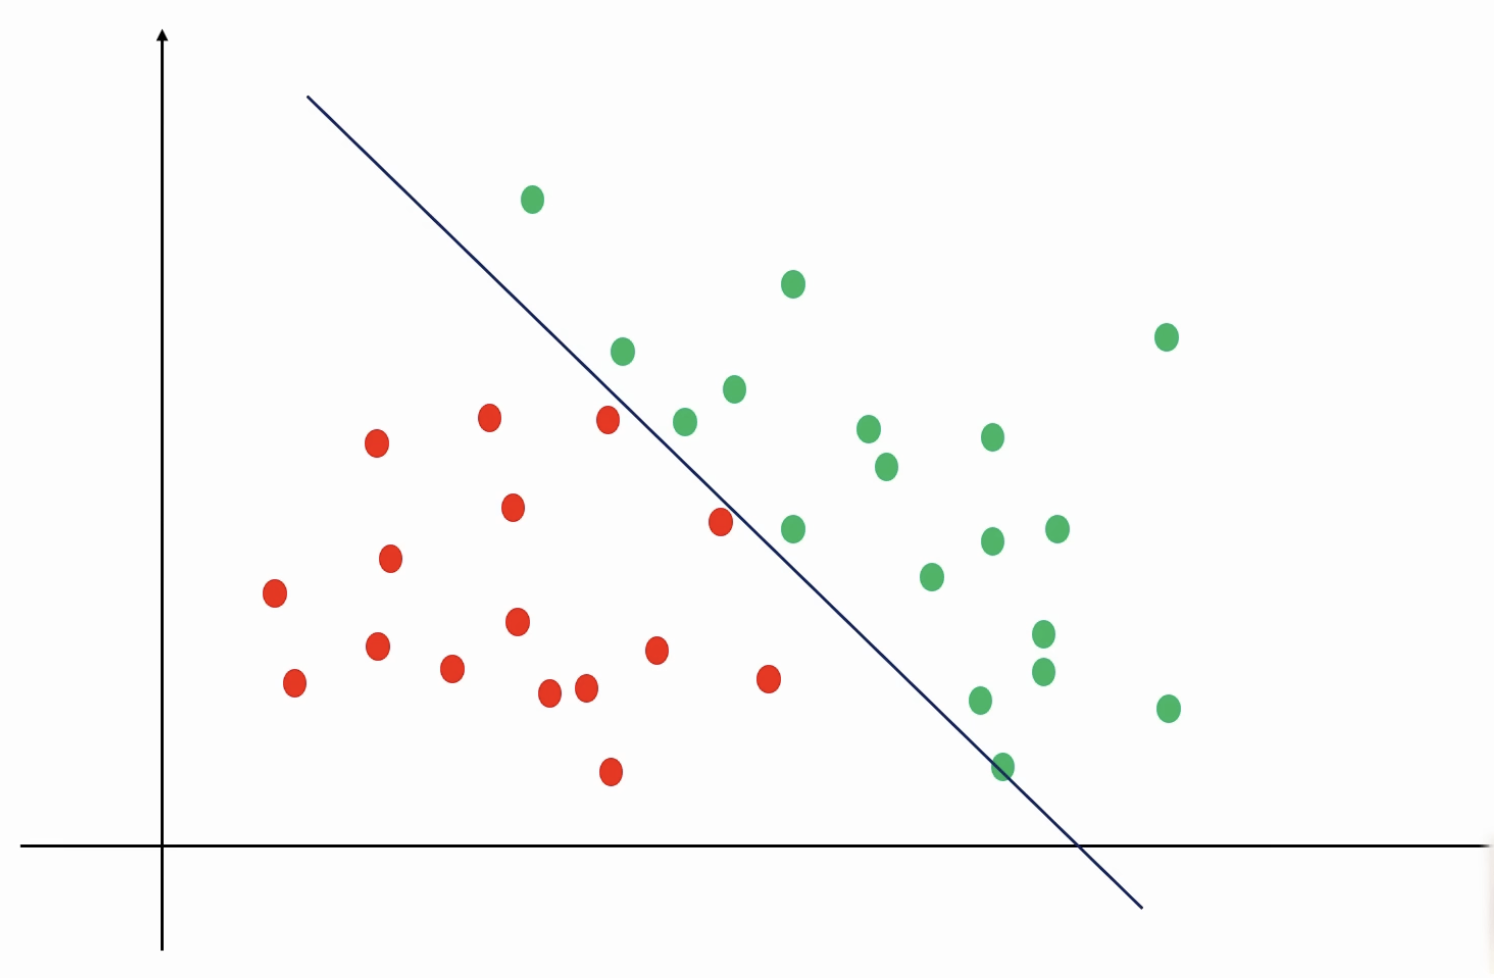

When our dataset looks like the above, it is easier to draw a decision boundary using Logistic Regression or find the optimal hyperplane using SVM because the classes can be cleanly divided by a straight line or hyperplane.

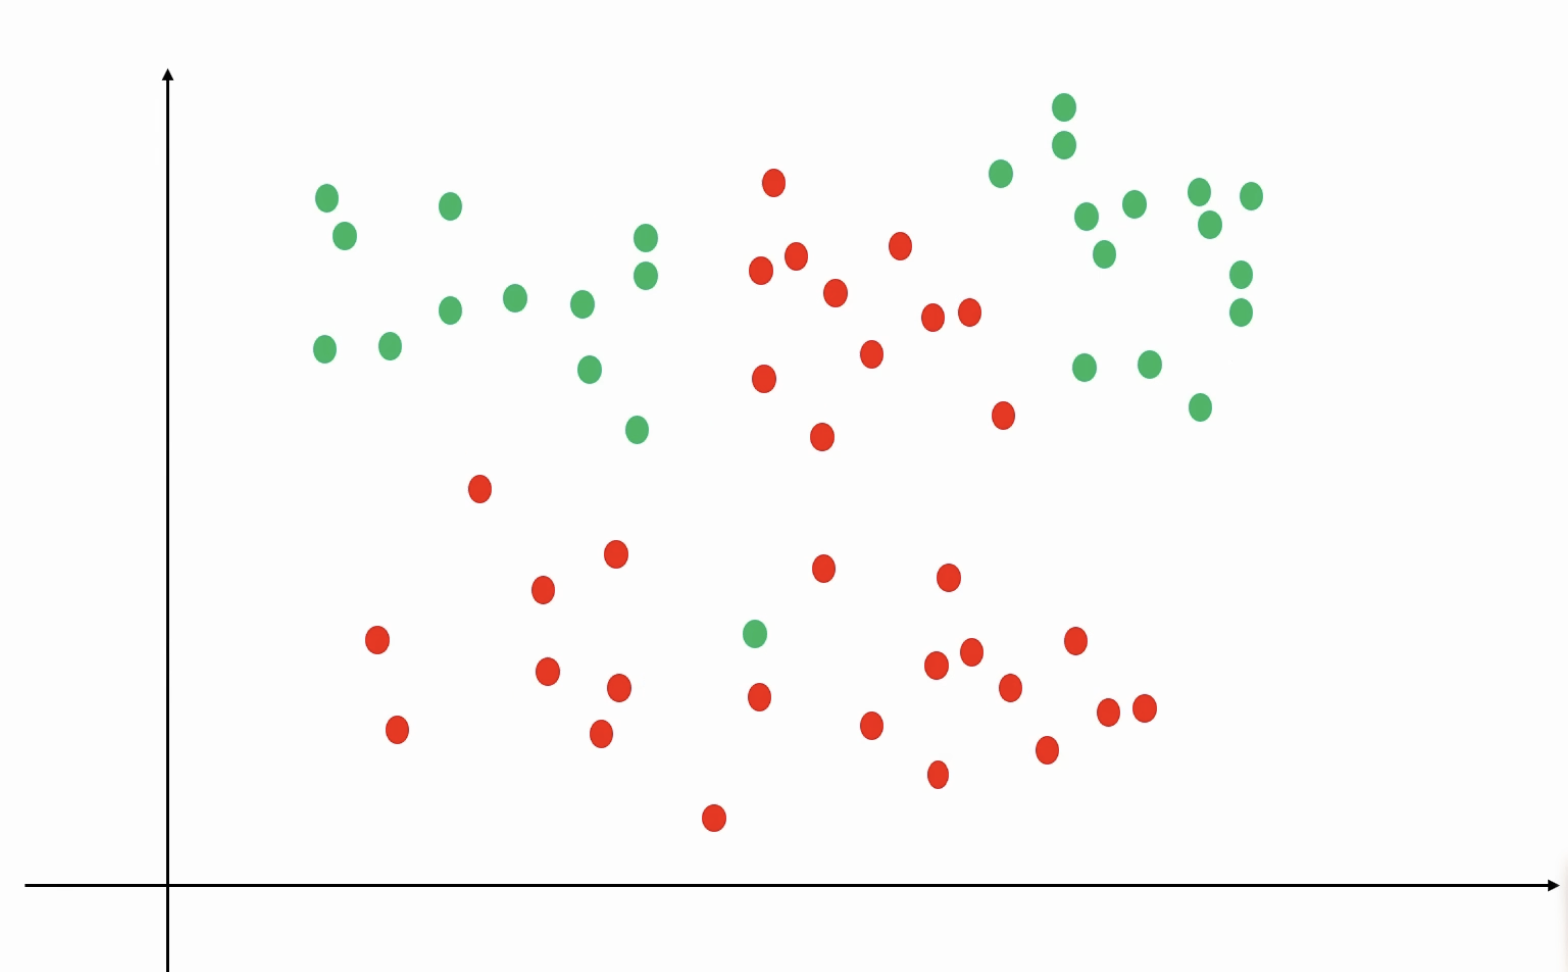

But when our dataset has significant overlap in the feature space like this, a single boundary is not adequate to divide them without many errors. In such cases, a Decision Tree is more appropriate. The hierarchical branching of this algorithm is  helpful for non-linear data where straight lines do not work, as the multiple levels let the model draw complex, adaptive boundaries.


> **How it applies to the Car Evaluation dataset**

Based on categorical features like buying price, maintenance cost, safety, etc., each car is rated as unacc, acc, good, or vgood.

The Decision Tree learns which attributes best predict car acceptability.
For example, it might find that safety and buying cost are the most decisive features.

The model builds a hierarchy like:

If safety = high → likely good or vgood

Else if safety = med → maybe acc

Else → unacc


Now, we proceed to working with the dataset directly.

# Installing necessary packages
Here we import all relevant libraries and fetch the dataset.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [30]:
pip install ucimlrepo

In [31]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
car_evaluation = fetch_ucirepo(id=19)

# data (as pandas dataframes)
X = car_evaluation.data.features
y = car_evaluation.data.targets

# metadata
print(car_evaluation.metadata)

# variable information
print(car_evaluation.variables)


{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'ID': 249, 'type': 'NATIVE', 'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'venue': '8th Intl Workshop on Expert Systems and their Applications, 

Since our dataset has no missing values, little to no cleaning is needed to run the model.

# Looking at the dataset
Here we look at the feature and target variables to get a general idea about the dataset.

In [ ]:
X.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [ ]:
X.shape

(1728, 6)

In [ ]:
y['class'].unique()

array(['unacc', 'acc', 'vgood', 'good'], dtype=object)

In [ ]:
y.value_counts()

,count
class,
unacc,1210
acc,384
good,69
vgood,65


# Preprocessing the Data
While Decision Tree Classifiers can theoretically handle categorical variables, in practice, some implementations like scikit-learn require categorical features to be numerically encoded. Since all the features in our dataset have categorical values, we encode them before running the model.

## Encoding

In [32]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder() #unlike OneHotEncoder this captures the natural ranking/ordinal relationship in the features (e.g. buying: vhigh > high, doors: 2<3<4)
X_encoded = encoder.fit_transform(X)

Although target variable in decision trees is inherently categorical, we encode them for the ROC curve and confusion matrix.

In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() #as target variable does not have an inherent order
y_encoded = le.fit_transform(y.ravel())

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Scaling has no impact on Decision Tree performance as it splits the data based on feature values relative to each other and not in terms of absolute magnitude. So, we do not used any scalers.

## Data Split
We import our model and evaluation scores from scikit-learn. We use a train-test split (80% Training, 20% Test) to check how well our model will perform on unseen data.

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.20, stratify=y)
# X_encoded and y_encoded contain the numerical features and target
# The test size parameter indicates the proportion of data to be used for testing
# Stratify parameter ensures that the training and test sets will have the same class proportions as the original data

## Model Fitting

In [35]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=8, random_state=56) #max_depth to balance overfitting, fixed random state so that runs are reproducible
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, random_state=56)

# Running the Model


## Decision Tree Plot

Now we visualize our model. Decision tree uses Gini impurity to split the data into subsets based on feature values.

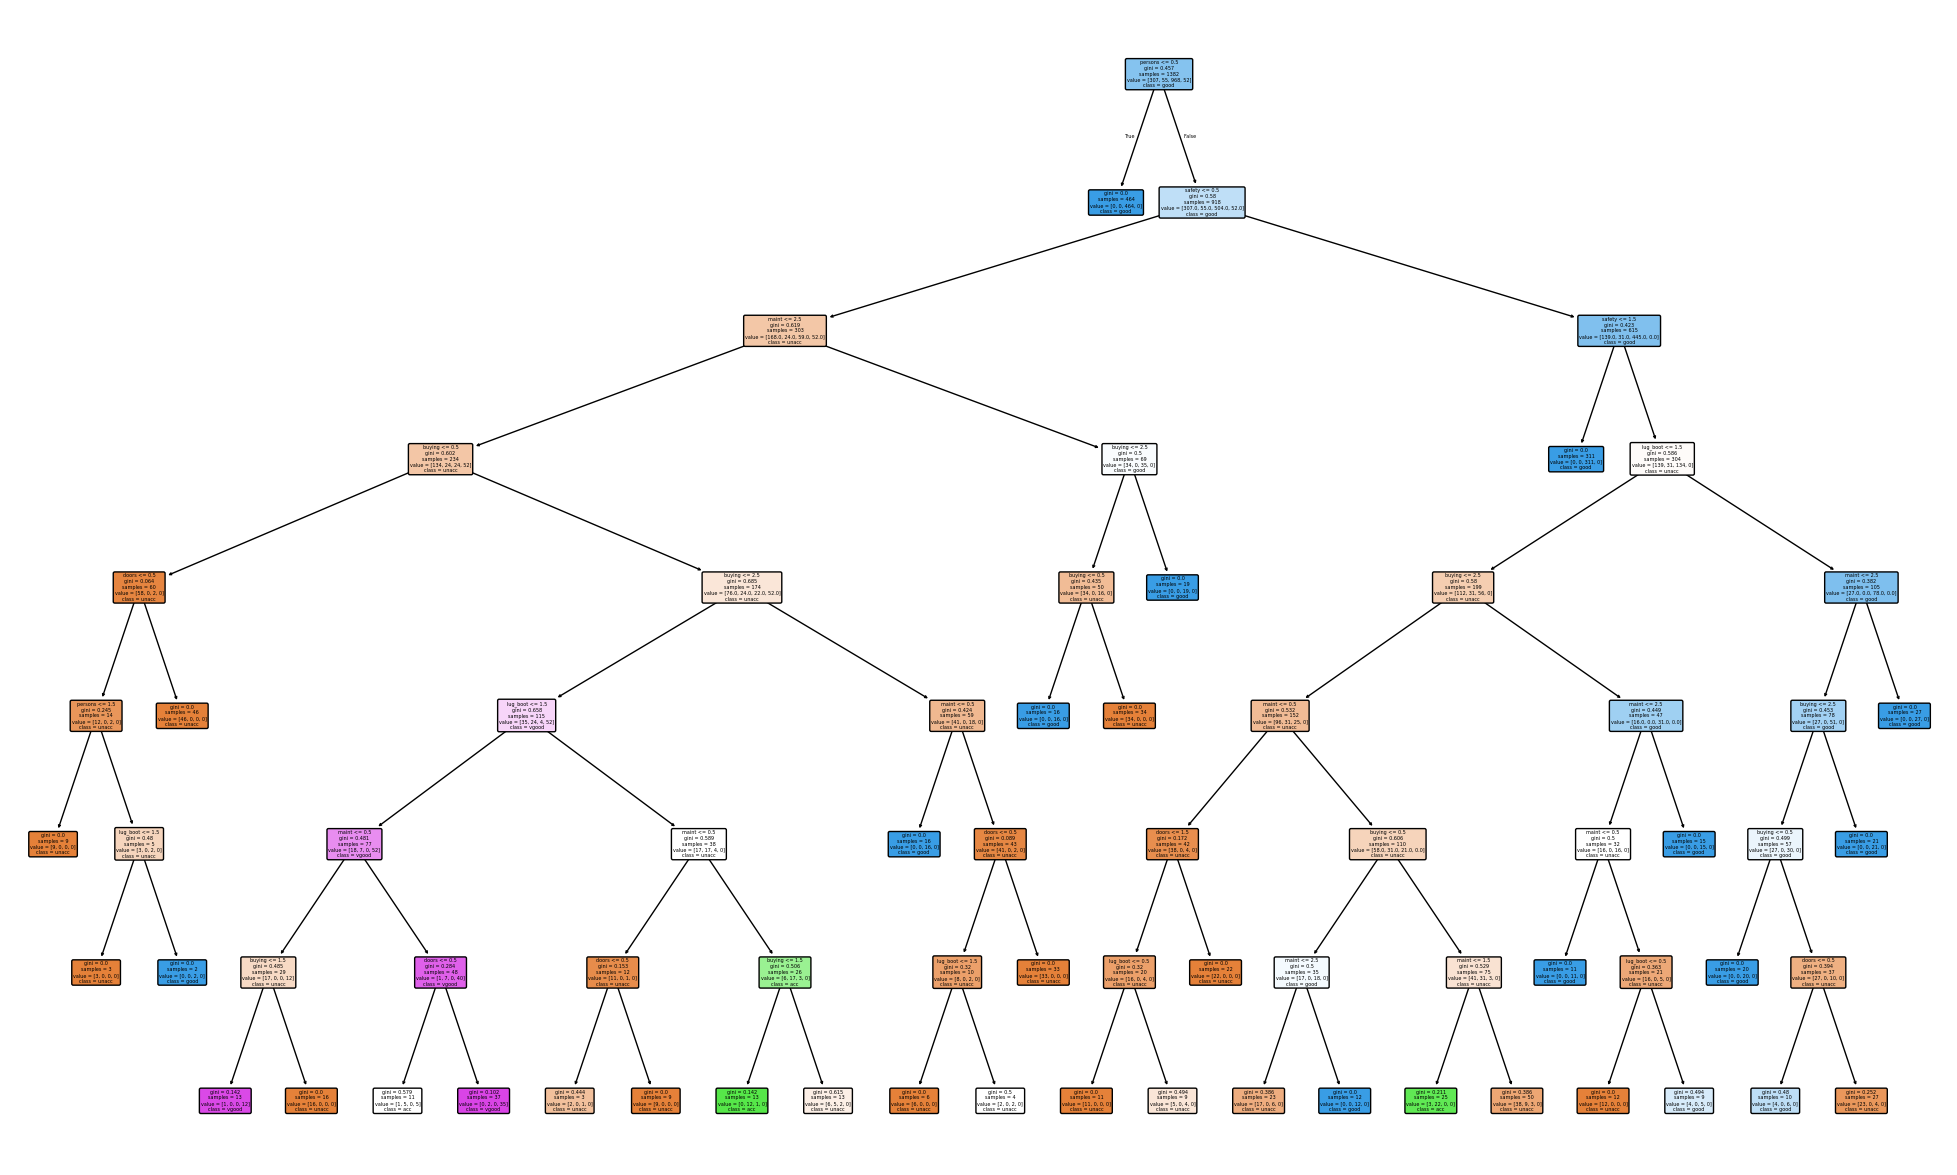

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(25,15))
plot_tree(clf,
          rounded= True,
          filled=True,
          feature_names=X.columns.to_list(), #names of the features to display in the tree nodes
          class_names=["unacc", "acc", "good", "vgood"]) #class labels for leaf nodes to display readable predictions
plt.show()

## Confusion Matrix

In [36]:
y_pred = clf.predict(X_test)

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 65,   6,   6,   0],
       [  0,  10,   3,   1],
       [  4,   0, 238,   0],
       [  0,   2,   0,  11]])

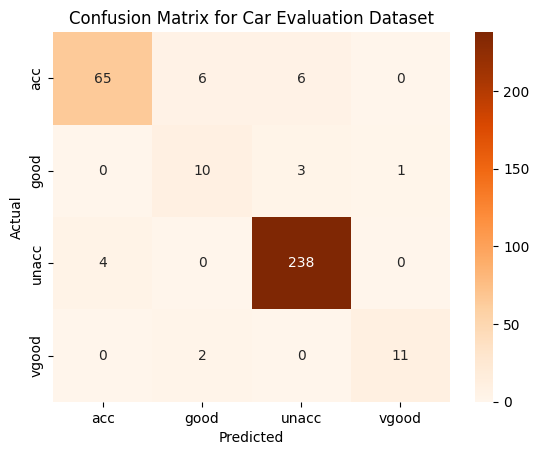

In [38]:
class_labels = le.classes_

sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Car Evaluation Dataset')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Model Performance

In [39]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")

class_labels = le.classes_  # ['acc', 'good', 'unacc', 'vgood']
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels))

Accuracy: 0.94
Precision: 0.94
Recall: 0.94
Classification Report:
              precision    recall  f1-score   support

         acc       0.94      0.84      0.89        77
        good       0.56      0.71      0.62        14
       unacc       0.96      0.98      0.97       242
       vgood       0.92      0.85      0.88        13

    accuracy                           0.94       346
   macro avg       0.84      0.85      0.84       346
weighted avg       0.94      0.94      0.94       346



The target variable 'unacc' shows excellent performance as the majority class, 'acc' also shows strong performance while 'good' is the weakest class. The model reliably identifies acceptable cars with balanced precision/recall, excels at flagging unacceptable cars but confuses good cars with other classes.

## ROC Curve

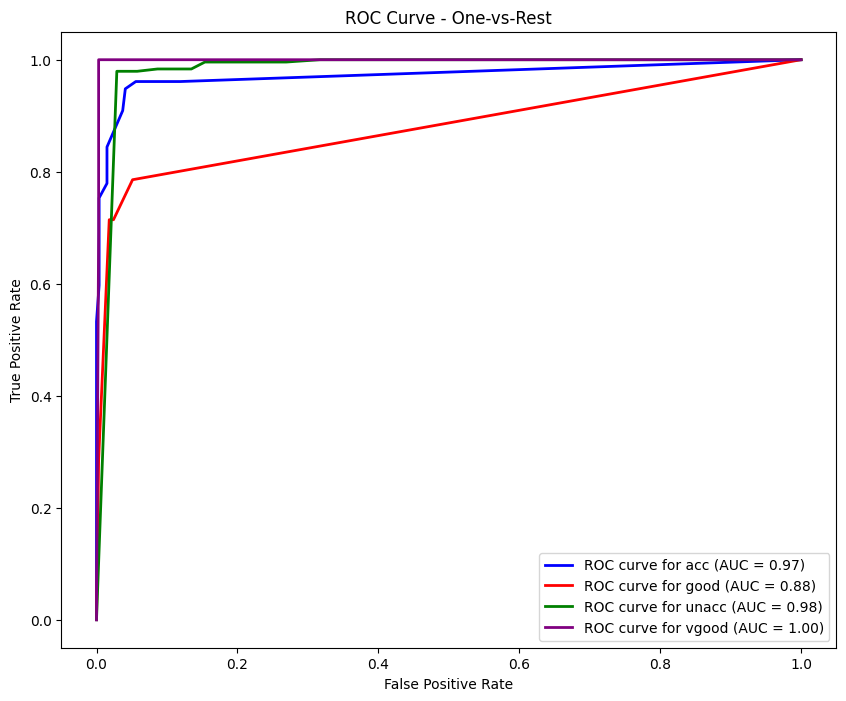

AUC Scores:
acc: 0.9725
good: 0.8797
unacc: 0.9826
vgood: 0.9980


In [40]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.arange(len(class_labels))) #converts class labels into a binary (0/1) format; necessary for plotting ROC curves in multi-class problem

y_score = clf.predict_proba(X_test) #probability that each test sample belongs to each class

fpr = dict()
tpr = dict()
roc_auc = dict() #Empty dictionaries to store the False Positive Rate, True Positive Rate, and AUC for each class

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i]) #returns FPR and TPR values at different thresholds
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = ['blue','red','green','purple'] # safe slicing
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One-vs-Rest')
plt.legend(loc="lower right")
plt.show()

# Print AUC for each class
print("AUC Scores:")
for i in range(len(class_labels)):
    print(f"{class_labels[i]}: {roc_auc[i]:.4f}")

We see that the model has high AUC scores across all targets, indicating strong model performance.

## Dummy Classifier for Baseline

Let's run this dataset with a **dummy classifier** to have a benchmark to compare our model to. If our DT model doesn’t perform better than this baseline, it means our model isn’t actually learning useful patterns; it’s just guessing like the baseline.

In [ ]:
from sklearn.dummy import DummyClassifier #creates a baseline model that doesn’t actually “learn” anything
from sklearn.metrics import classification_report

baseline = DummyClassifier(strategy='most_frequent') #dummy model that always predicts the most common class from the training data
# The most common class is used as a baseline because it’s the easiest possible prediction to make without learning anything

baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred_baseline))

Baseline Accuracy: 0.6994219653179191


Since DT model accuracy is greater than the baseline accuracy, the model is performing better than chance and can provide real value if implemented.

## Cross Validation

In [41]:
from sklearn.model_selection import StratifiedKFold, cross_val_score #cross-validation tools to test model reliability

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=56) #10-fold cross-validation setup

scores = cross_val_score(clf, X_encoded, y_encoded, cv=skf, scoring='accuracy') #accuracy scores for each fold

# results
print(f"Accuracy in each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.2f}")

Accuracy in each fold: [0.95375723 0.92485549 0.94219653 0.92485549 0.94219653 0.93641618
 0.93063584 0.92485549 0.91860465 0.94767442]
Average Accuracy: 0.93


Since DT models can overfit, K-Fold Cross Validation helps test how robust and generalizable our model really is.

Instead of trusting one accuracy score, it gave K accuracy scores from 10 data splits thus making the evaluation more trustworthy and unbiased.


# Isolating a Path for New Feature Variable

Let us try creating a new variable from our existing features to see if it improves model performance.

In [42]:
#Isolating the path
from sklearn.tree import _tree

tree = clf.tree_
path = [False, False, False, True, True, True, True, False] #manually defined
current_node = 0
for val in path:
    if val:
        current_node = tree.children_left[current_node]
    else:
        current_node = tree.children_right[current_node]

leaf = clf.decision_path(X_train)
sample_indices = np.where(leaf[:, current_node].toarray() == 1)[0]

# Convert X_train back to a DataFrame before using iloc
X_train_df = pd.DataFrame(X_train, columns=X.columns)
path_samples = X_train_df.iloc[sample_indices]


print(f"Number of samples in this node: {len(sample_indices)}")
print(path_samples)

Number of samples in this node: 30
      buying  maint  doors  persons  lug_boot  safety
2        1.0    0.0    1.0      2.0       1.0     2.0
27       0.0    0.0    1.0      2.0       1.0     2.0
47       1.0    0.0    2.0      1.0       0.0     2.0
61       0.0    0.0    3.0      1.0       0.0     2.0
109      2.0    0.0    1.0      2.0       0.0     2.0
152      0.0    0.0    2.0      1.0       1.0     2.0
251      0.0    0.0    2.0      2.0       0.0     2.0
261      0.0    0.0    1.0      1.0       0.0     2.0
345      0.0    0.0    2.0      2.0       1.0     2.0
421      2.0    0.0    3.0      1.0       0.0     2.0
461      0.0    0.0    3.0      2.0       1.0     2.0
473      2.0    0.0    2.0      2.0       1.0     2.0
492      2.0    0.0    1.0      1.0       1.0     2.0
518      2.0    0.0    2.0      1.0       0.0     2.0
609      2.0    0.0    2.0      2.0       0.0     2.0
750      1.0    0.0    1.0      1.0       0.0     2.0
830      1.0    0.0    1.0      1.0       1.0  

In [43]:
for column in path_samples.columns:
    print(f"{column}: {path_samples[column].mode()[0]}")

buying: 0.0
maint: 0.0
doors: 1.0
persons: 2.0
lug_boot: 0.0
safety: 2.0


In [44]:
print("Value counts for each column in path_samples:")
for column in path_samples.columns:
    print(f"\n--- {column} ---")
    print(path_samples[column].value_counts())

Value counts for each column in path_samples:

--- buying ---
buying
1.0    10
0.0    10
2.0    10
Name: count, dtype: int64

--- maint ---
maint
0.0    30
Name: count, dtype: int64

--- doors ---
doors
1.0    11
2.0    11
3.0     8
Name: count, dtype: int64

--- persons ---
persons
2.0    16
1.0    14
Name: count, dtype: int64

--- lug_boot ---
lug_boot
0.0    16
1.0    14
Name: count, dtype: int64

--- safety ---
safety
2.0    30
Name: count, dtype: int64


From the existing columns, we create a new variable combining buying and maintenance.

In [45]:
# Convert X_train back to a DataFrame before adding the new column
X_train_df = pd.DataFrame(X_train, columns=X.columns)

X_train_df['owner_miser'] = (
    (X_train_df['buying'] == 0.0) & (X_train_df['maint'] == 0.0) # Use numerical values after encoding
).astype(int)

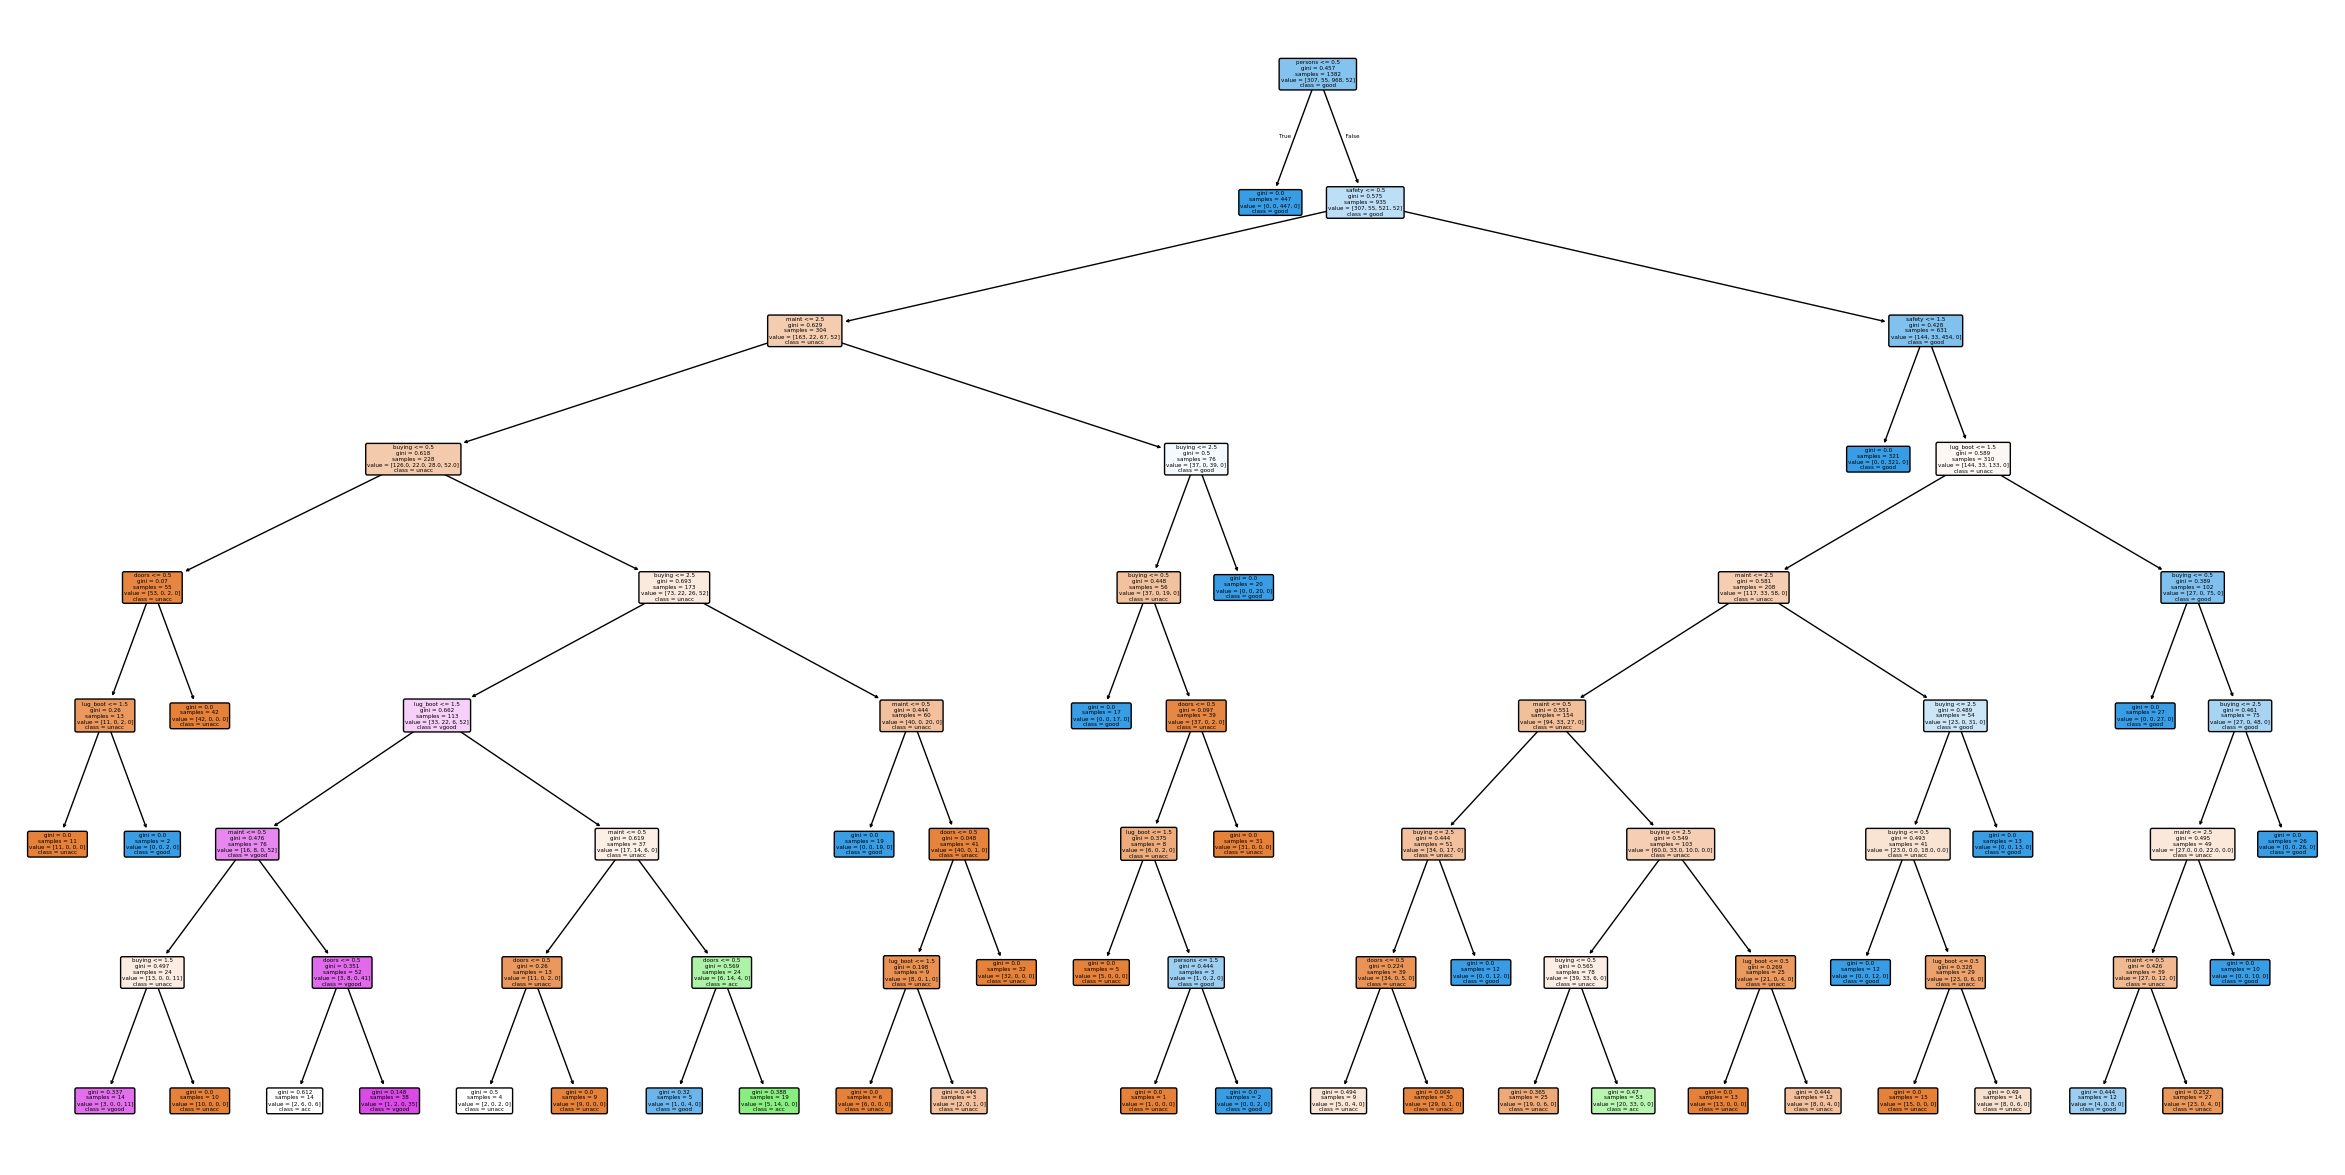

In [46]:
# Fit DT to a new variable to preserve the original model
clf1 = DecisionTreeClassifier(random_state=56, max_depth=8)
clf1.fit(X_train_df, y_train)

plt.figure(figsize=(30,15))
plot_tree(clf1,
          rounded= True,
          filled=True,
          feature_names=X_train_df.columns.to_list(),
          class_names=["unacc", "acc", "good", "vgood"])
plt.show()

In [48]:
# Convert X_test back to a DataFrame before adding the new column
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Add the new feature to the test set in the same way it was added to the training set
X_test_df['owner_miser'] = (
    (X_test_df['buying'] == 0.0) & (X_test_df['maint'] == 0.0) # Use numerical values after encoding
).astype(int)

# Use clf1, which was trained with the 'owner_miser' feature
y_pred1 = clf1.predict(X_test_df)

# Scores
acc_df = accuracy_score(y_test, y_pred1)
prec_df = precision_score(y_test, y_pred1, average='weighted')
rec_df = recall_score(y_test, y_pred1, average='weighted')

print(f"Accuracy: {acc_df:.2f}")
print(f"Precision: {prec_df:.2f}")
print(f"Recall: {rec_df:.2f}")

Accuracy: 0.94
Precision: 0.94
Recall: 0.94


We conclude that this specific path isolation did not bring forth any model improvement.

# DT model with optimized max_depth
Earlier, we guessed a depth value of 8 for our model. Let us now try using a helper that tests multiple options using cross-validation. It will help us find the depth that gives the best generalization performance so the model performs well not just on training data but also on unseen data.

At first, we check the full length i.e., how much the tree actually grows without any maximum limit.

In [49]:
clf2 = DecisionTreeClassifier(random_state=56) #fixed random state so that runs are reproducible
clf2.fit(X_train, y_train)
clf2.tree_.max_depth

14

In [50]:
from sklearn.model_selection import GridSearchCV #runs the model many times with different hyperparameters and cross-validates them
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_depth': range(1, 15)}  # test depths from 1 to 14 (max)

grid_search = GridSearchCV(clf2, param_grid, cv=5, scoring='accuracy') #5-fold cross validation for every max depth (param_grid) using accuracy as the metric
grid_search.fit(X_train, y_train)

print("Best max_depth:", grid_search.best_params_) #returns the hyperparameters that gave the best mean CV score
print("Best accuracy:", grid_search.best_score_) #average validation accuracy across folds for that best parameter

Best max_depth: {'max_depth': 12}
Best accuracy: 0.9761314288704023


In [51]:
test_acc = grid_search.score(X_test, y_test) #confirming the estimate by evaluating the refitted model on a held-out test set
print(f"Test accuracy: {test_acc:.2f}")

Test accuracy: 0.97


We can see that the accuracy on test dataset has improved compared to our original model where the maximum depth was an educated guess.